In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import json,sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
%matplotlib inline

In [20]:
feats = []
count = 0;
for line in open("../stats/all_buildings.geojsonseq"):
    x = json.loads(line.strip())
    feats.append({
        'id':x['properties']["@id"],
        'date':x['properties']["@timestamp"],
        'user':x['properties']['@user'],
        'cset':x['properties']['@changeset']
    })
    count+=1
    if count%10000==0:
        sys.stderr.write("\r"+str(count))
print("Making Dataframe")
df = pd.DataFrame(feats)
print("Done")

250000

Making Dataframe
Done


In [21]:
tqdm.pandas()
df['d'] = df['date'].progress_apply(lambda x: pd.Timestamp(x*1000000000).date())

100%|██████████| 251496/251496 [00:00<00:00, 466393.13it/s]


In [22]:
df.head(1)

,cset,date,id,user,d
0,25949360,1412803035,358921206,sporobolus,2014-10-08


In [23]:
df['id'].count(), df['id'].nunique(), df['user'].nunique()

(251496, 251488, 1195)

Show the growth of some buildings...

In [24]:
gb_date = df.groupby('d')

Text(0.5,1,'Cumulative count of buildings added to OSM in the Denver area')

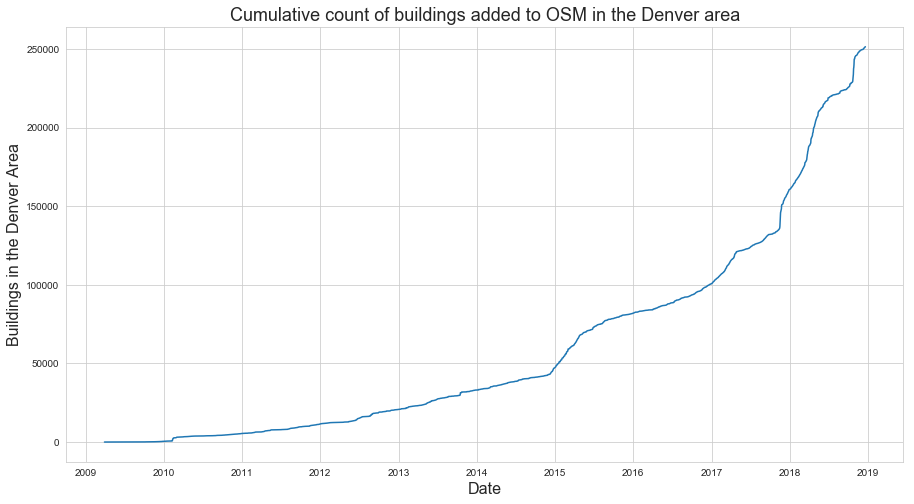

In [25]:
sns.set_style('whitegrid')
ax = gb_date.aggregate({'id':'nunique'}).cumsum().plot(figsize=(15,8),legend=None)
ax.set_xlabel("Date",fontsize=16)
ax.set_ylabel("Buildings in the Denver Area",fontsize=16)
ax.set_title('Cumulative count of buildings added to OSM in the Denver area',fontsize=18)

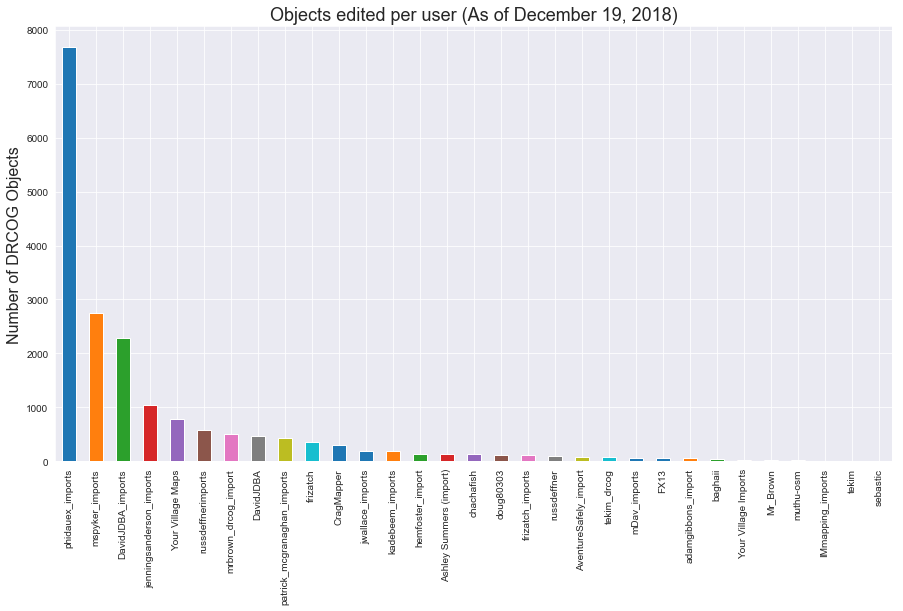

In [5]:
sns.set_style('darkgrid')
ax = df.user.value_counts().plot(kind='bar', figsize=(15,8))
ax.set_ylabel("Number of buildings per active user",fontsize=16)
ax.set_title("Objects edited per user (As of December 19, 2018)",fontsize=18);

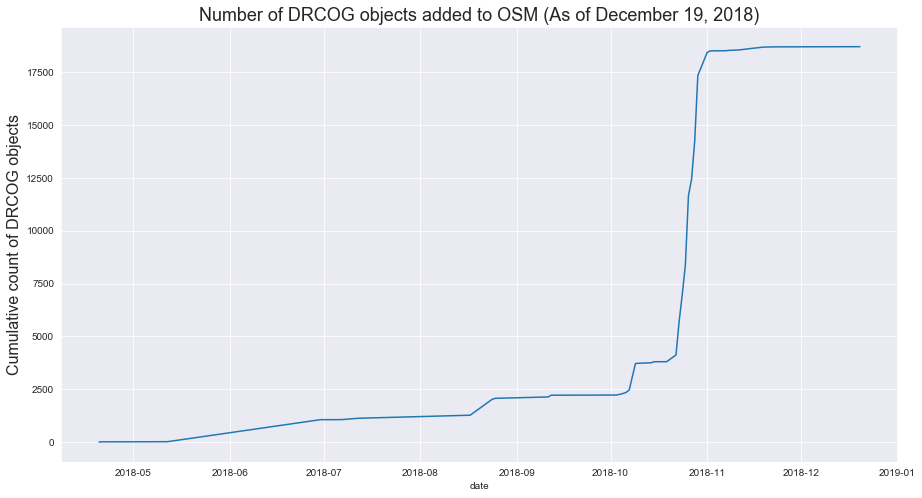

In [6]:
sns.set_style('darkgrid')
ax = df.groupby('date').aggregate({'@id':'count'}).cumsum().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Cumulative count of DRCOG objects", fontsize=16)
ax.set_title("Number of DRCOG objects added to OSM (As of December 19, 2018)",fontsize=18);

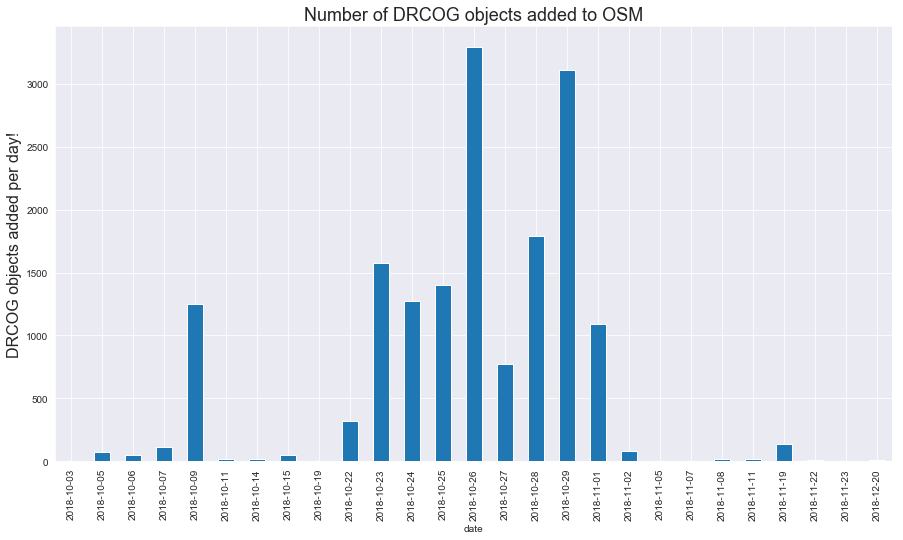

In [7]:
sns.set_style('darkgrid')
ax = df[df.date > datetime.date(2018,10,1)].groupby('date').aggregate({'@id':'count'}).plot(kind='bar',figsize=(15,8),legend=None)
ax.set_ylabel("DRCOG objects added per day!", fontsize=16)
ax.set_title("Number of DRCOG objects added to OSM",fontsize=18);


In [8]:
combined_df = []
count =0;
for u,items in df[df.date > datetime.date(2018,10,1)].groupby('user'):
    if len(items)>0:
        new_df = items.groupby('date').aggregate({"@id":'count'})
        new_df.columns=[u]
        if count==0:
            combined_df = new_df
        else:
            combined_df = combined_df.join(new_df, how='outer')
        count+=1


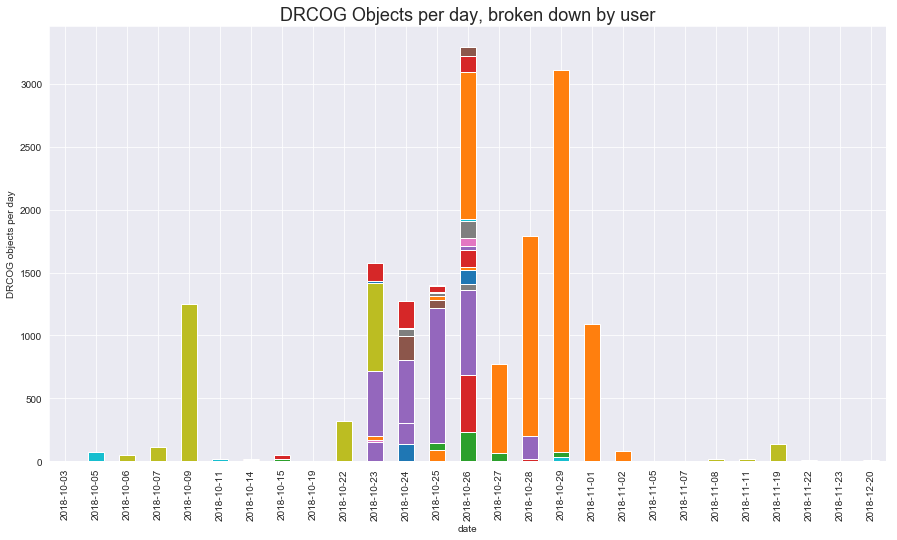

In [9]:
ax = combined_df.plot(kind='bar',stacked=True,figsize=(15,8),legend=False)
ax.set_ylabel("DRCOG objects per day")
ax.set_title("DRCOG Objects per day, broken down by user",fontsize=18);

In [10]:
new_df.head()

,tekim_drcog
date,
2018-10-26,74


In [11]:
df[df.date > datetime.date(2018,10,1)].count()

@changeset           16486
@id                  16486
@timestamp           16486
@type                16486
@uid                 16486
@user                16486
@version             16486
FIXME                    1
addr:apartment           0
addr:city            15022
addr:country             0
addr:housename           0
addr:housenumber     10793
addr:postcode        15021
addr:state           15021
addr:street          10952
addr:unit                2
alt_name                 1
amenity                 21
attraction               0
barrier                  0
building             16403
building:colour          2
building:levels         16
contact:phone            1
cuisine                  1
denomination             6
ele                     13
emergency                1
fixme                    1
                     ...  
gnis:state_id           12
height               16406
heritage                 2
heritage:operator        2
historic                 2
landuse                 76
l

In [12]:
gb_user = buildings.groupby('user').aggregate({'validSince':min, 'validUntil':max, 'version':'count','id':'nunique'})

NameError: name 'buildings' is not defined

In [268]:
gb_user['firstBuilding'] = gb_user.validSince.apply(lambda t: pd.Timestamp(t*1000000000).date())
gb_user['lastBuilding'] = gb_user.validUntil.apply(lambda t: pd.Timestamp(t*1000000000).date())

In [270]:
gb_user.head()

,validSince,validUntil,version,id,firstBuilding,lastBuilding
user,,,,,,
$agar11,1461967263,1535673544,7,6,2016-04-29,2018-08-30
+rama,1424001018,1424248590,1,1,2015-02-15,2015-02-18
-Christoph-,1429983843,1535673544,463,463,2015-04-25,2018-08-30
0109,1430289805,1431014646,1,1,2015-04-29,2015-05-07
048,1430455711,1535673544,40,40,2015-05-01,2018-08-30


Text(0.5,1,'Timespan of OSM Contributions to Buildings in Nepal')

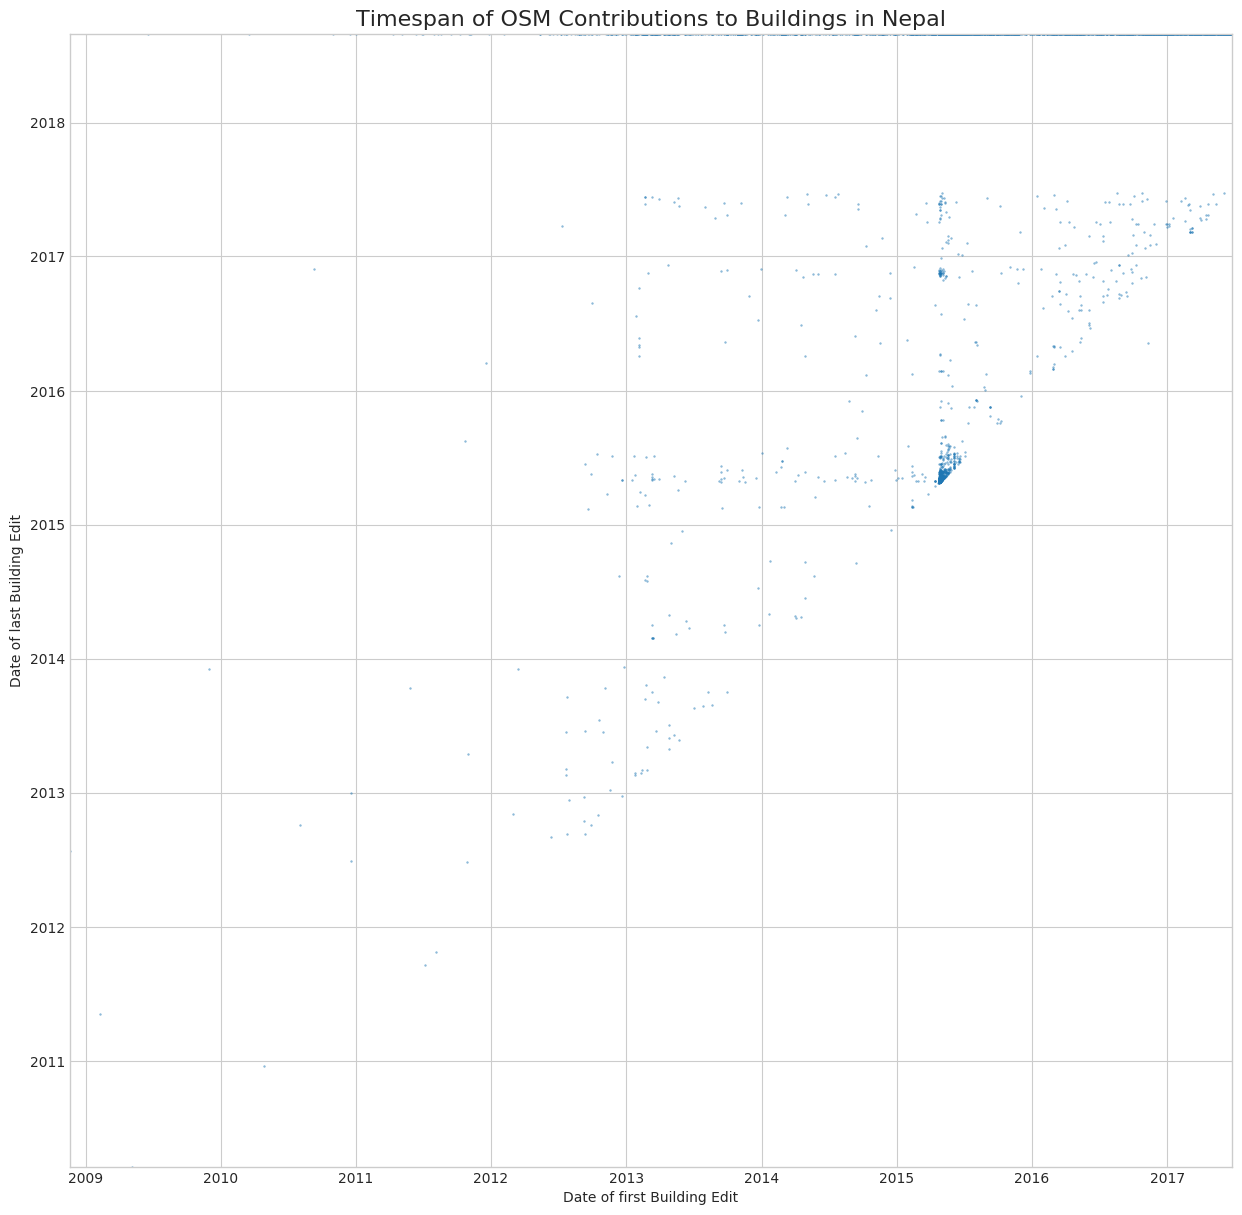

In [275]:
sns.set_style('whitegrid')
plt.figure(num=None, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')
plt.plot(gb_user['firstBuilding'], gb_user['lastBuilding'], '+', markersize=2, alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().yaxis.set_major_locator(mdates.YearLocator())
plt.xlim([gb_user.firstBuilding.min() , gb_user.firstBuilding.max()])
plt.ylim([gb_user.lastBuilding.min(), gb_user.lastBuilding.max()])
plt.xlabel('Date of first Building Edit')
plt.ylabel('Date of last Building Edit')
plt.title("Timespan of OSM Contributions to Buildings in Nepal",fontsize=16)
# plt.savefig('/data/www/jennings/osm-timespans.png')

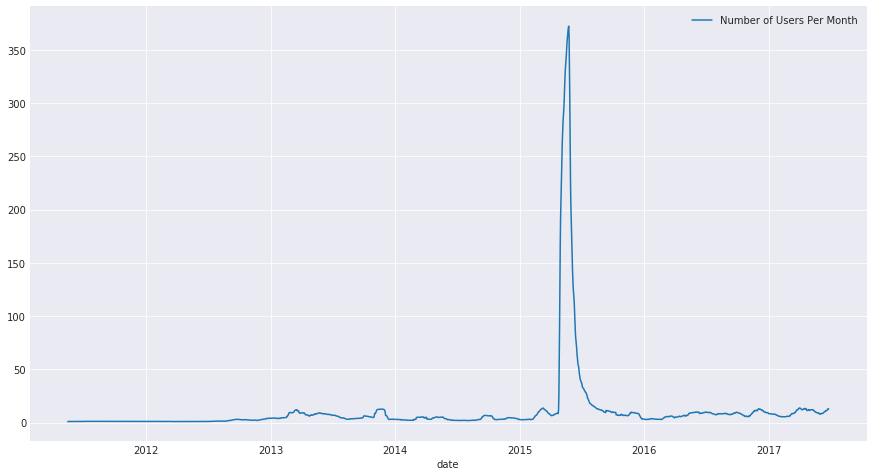

In [310]:
ax = gb_dates.user.rolling(30).mean().plot(figsize=(15,8))
ax.legend(["Number of Users Per Month"])

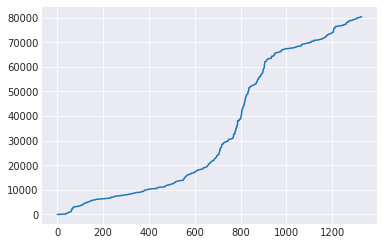

In [337]:
buildings.groupby('date',as_index=False).aggregate({'user':pd.Series.nunique, 'version':sum}).version.cumsum().plot()